In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mail-customers/Mall_Customers.csv


## Loading Data Set

In [2]:
Mall_Customers_Data = pd.read_csv('/kaggle/input/mail-customers/Mall_Customers.csv')
Mall_Customers_Data

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


In [3]:
summary_stats = Mall_Customers_Data.describe(include='all')
summary_stats

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200,200.000000,200.000000,200.000000
unique,NaN,2,NaN,NaN,NaN
top,NaN,Female,NaN,NaN,NaN
freq,NaN,112,NaN,NaN,NaN
mean,100.500000,NaN,38.850000,60.560000,50.200000
std,57.879185,NaN,13.969007,26.264721,25.823522
min,1.000000,NaN,18.000000,15.000000,1.000000
25%,50.750000,NaN,28.750000,41.500000,34.750000
50%,100.500000,NaN,36.000000,61.500000,50.000000
75%,150.250000,NaN,49.000000,78.000000,73.000000


## Data Cleaning

In [4]:
# Check if there na values
Mall_Customers_Data.isna().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [5]:
# Check if there duplicates
duplicates = Mall_Customers_Data.duplicated().sum()
duplicates

0

In [6]:
# Convert Gender to numerical values
data_encoded = pd.get_dummies(Mall_Customers_Data, columns=['Gender'], drop_first=True)
data_encoded

,CustomerID,Age,Annual Income (k$),Spending Score (1-100),Gender_Male
0,1,19,15,39,True
1,2,21,15,81,True
2,3,20,16,6,False
3,4,23,16,77,False
4,5,31,17,40,False
...,...,...,...,...,...
195,196,35,120,79,False
196,197,45,126,28,False
197,198,32,126,74,True
198,199,32,137,18,True


In [7]:
# Remove the CustomerID column as it may not be useful
data_cleaned = data_encoded.drop(columns=['CustomerID'])
data_cleaned

,Age,Annual Income (k$),Spending Score (1-100),Gender_Male
0,19,15,39,True
1,21,15,81,True
2,20,16,6,False
3,23,16,77,False
4,31,17,40,False
...,...,...,...,...
195,35,120,79,False
196,45,126,28,False
197,32,126,74,True
198,32,137,18,True


In [8]:
# Standardize the numerical features
scaler = StandardScaler()
data_scaled = data_cleaned.copy()
data_scaled[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']] = scaler.fit_transform( 
    data_cleaned[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']])
data_scaled

,Age,Annual Income (k$),Spending Score (1-100),Gender_Male
0,-1.424569,-1.738999,-0.434801,True
1,-1.281035,-1.738999,1.195704,True
2,-1.352802,-1.700830,-1.715913,False
3,-1.137502,-1.700830,1.040418,False
4,-0.563369,-1.662660,-0.395980,False
...,...,...,...,...
195,-0.276302,2.268791,1.118061,False
196,0.441365,2.497807,-0.861839,False
197,-0.491602,2.497807,0.923953,True
198,-0.491602,2.917671,-1.250054,True


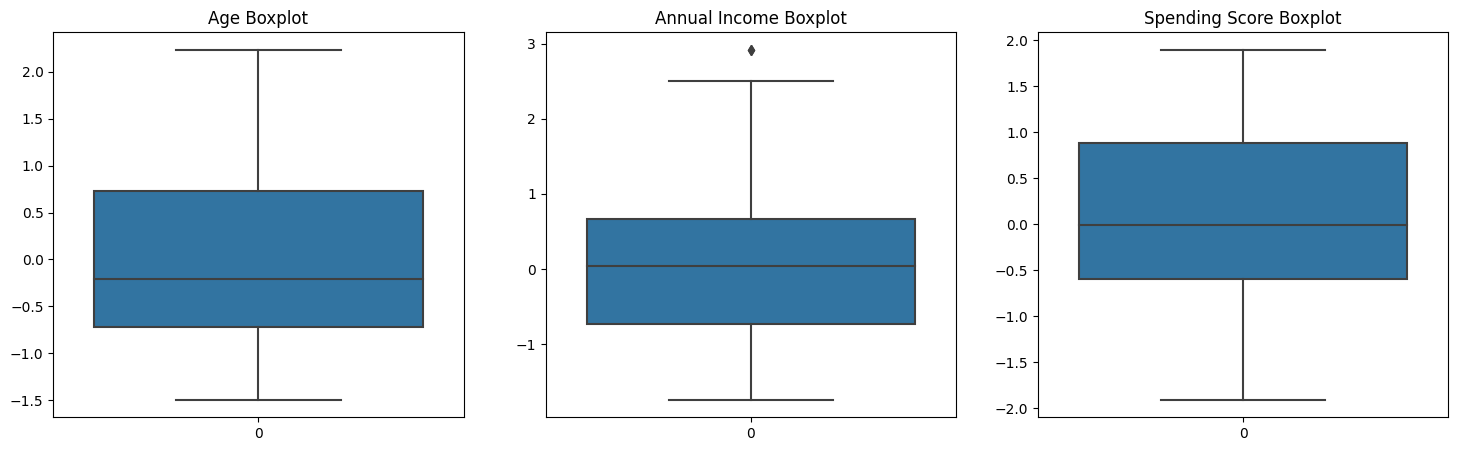

In [9]:
# Boxplots to detect outliers
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.boxplot(data_scaled['Age'], ax=axes[0])
axes[0].set_title('Age Boxplot')

sns.boxplot(data_scaled['Annual Income (k$)'], ax=axes[1])
axes[1].set_title('Annual Income Boxplot')

sns.boxplot(data_scaled['Spending Score (1-100)'], ax=axes[2])
axes[2].set_title('Spending Score Boxplot')

plt.show()

In [10]:
# Removing outliers
Q1 = data_scaled['Annual Income (k$)'].quantile(0.25)
Q3 = data_scaled['Annual Income (k$)'].quantile(0.75)
IQR = Q3 - Q1
Income_outliers = (data_scaled['Annual Income (k$)'] < (Q1 - 1.5 * IQR)) | (data_scaled['Annual Income (k$)'] > (Q3 + 1.5 * IQR))
data_clean = data_scaled[~Income_outliers]

In [11]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 198 entries, 0 to 197
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     198 non-null    float64
 1   Annual Income (k$)      198 non-null    float64
 2   Spending Score (1-100)  198 non-null    float64
 3   Gender_Male             198 non-null    bool   
dtypes: bool(1), float64(3)
memory usage: 6.4 KB


<Axes: >

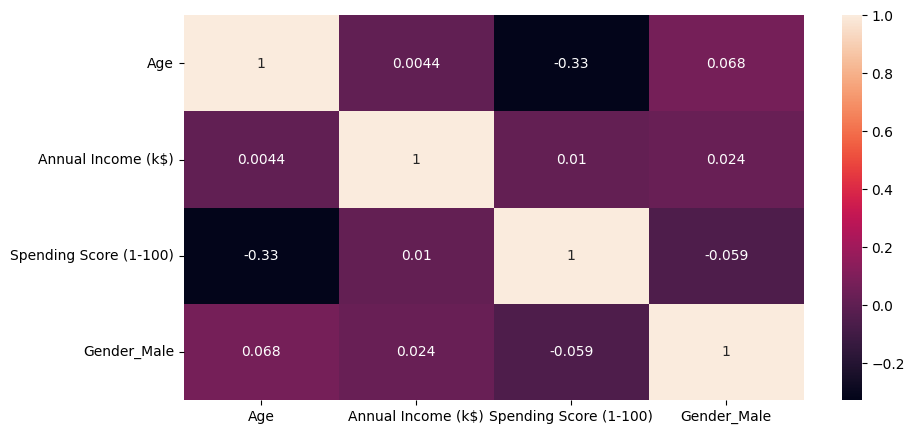

In [12]:
plt.figure(figsize = (10, 5))
sns.heatmap(data_clean.corr(), annot = True)

## Plot and Determine Clusters

### K-Means

In [13]:
# Determine how many clusters is better for this data|
wcss = []
for i in range (1,15):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter =300, n_init = 10, random_state = 0)
    kmeans.fit(data_clean)
    wcss.append(kmeans.inertia_)
    print('WCSS for k = {}: {:<.3f}'.format(i, kmeans.inertia_))

WCSS for k = 1: 627.613
WCSS for k = 2: 418.629
WCSS for k = 3: 330.262
WCSS for k = 4: 245.686
WCSS for k = 5: 208.467
WCSS for k = 6: 173.644
WCSS for k = 7: 156.522
WCSS for k = 8: 146.367
WCSS for k = 9: 130.919
WCSS for k = 10: 122.711
WCSS for k = 11: 112.503
WCSS for k = 12: 109.188
WCSS for k = 13: 101.530
WCSS for k = 14: 93.740


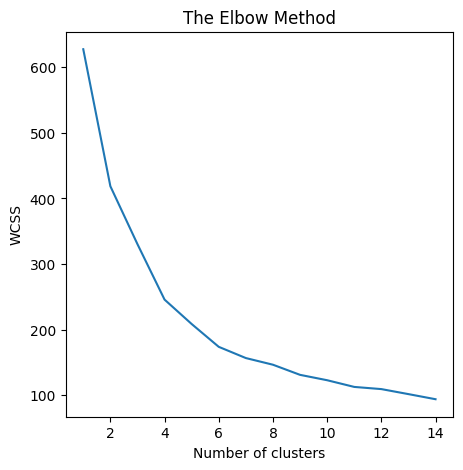

In [14]:
plt.figure(figsize = (5, 5))
plt.plot(range(1,15),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [15]:
#Using PCA to reduce dimensions
pca = PCA(n_components = 2)
data_clean_pca = pca.fit_transform(data_clean)
data_clean_pca.shape

(198, 2)

In [16]:
# Determine how many clusters is better for this data
wcss = []
for i in range (1,15):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter =300, n_init = 10, random_state = 0)
    kmeans.fit(data_clean_pca)
    wcss.append(kmeans.inertia_)
    print('WCSS for k = {}: {:<.3f}'.format(i, kmeans.inertia_))

WCSS for k = 1: 446.627
WCSS for k = 2: 237.691
WCSS for k = 3: 164.865
WCSS for k = 4: 114.816
WCSS for k = 5: 92.167
WCSS for k = 6: 75.296
WCSS for k = 7: 64.582
WCSS for k = 8: 54.687
WCSS for k = 9: 46.721
WCSS for k = 10: 41.081
WCSS for k = 11: 37.653
WCSS for k = 12: 33.995
WCSS for k = 13: 31.023
WCSS for k = 14: 29.118


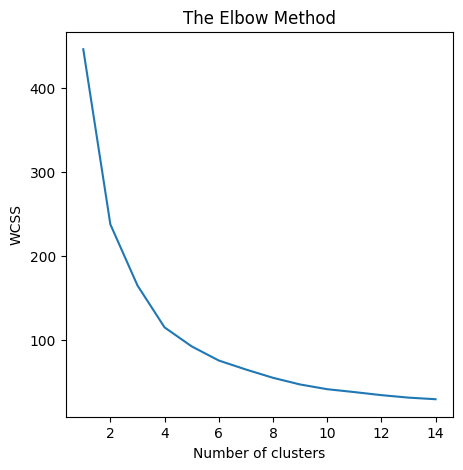

In [17]:
plt.figure(figsize = (5, 5))
plt.plot(range(1,15),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [18]:
# Apply K-Means clustering with 2 clusters
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(data_clean_pca)

# Add the cluster labels to the original data
data_clean['Cluster'] = kmeans.labels_+1
data_clean

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/tmp/ipykernel_36/4171357134.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['Cluster'] = kmeans.labels_+1


,Age,Annual Income (k$),Spending Score (1-100),Gender_Male,Cluster
0,-1.424569,-1.738999,-0.434801,True,2
1,-1.281035,-1.738999,1.195704,True,2
2,-1.352802,-1.700830,-1.715913,False,1
3,-1.137502,-1.700830,1.040418,False,2
4,-0.563369,-1.662660,-0.395980,False,2
...,...,...,...,...,...
193,-0.061002,2.001605,1.583920,False,2
194,0.584899,2.268791,-1.327697,False,1
195,-0.276302,2.268791,1.118061,False,2
196,0.441365,2.497807,-0.861839,False,1


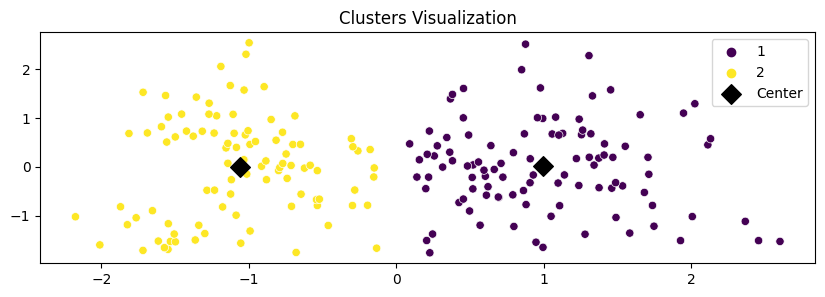

Cluster Centers:
[[ 0.99655401  0.00624301]
 [-1.05883864 -0.0066332 ]]


In [19]:
# Visualize clusters based of K-Means
plt.figure(figsize=(10, 3))
sns.scatterplot(x=data_clean_pca[:, 0], y=data_clean_pca[:, 1], hue=data_clean['Cluster'], palette='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=100, c='black', marker='D', label='Center')
plt.title('Clusters Visualization')
plt.legend()
plt.show()

print("Cluster Centers:")
print(kmeans.cluster_centers_)


In [20]:
# Count numbers of data in each cluster
data_clean['Cluster'].value_counts()

Cluster
1    102
2     96
Name: count, dtype: int64

### GMM

Text(0.5, 0, 'Number of Clusters')

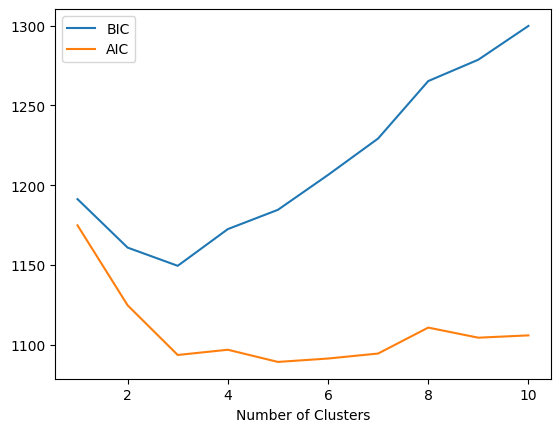

In [21]:
n_components = np.arange(1, 11)

models = [GaussianMixture(n_components=n, random_state=1502).fit(data_clean_pca) for n in n_components]

plt.plot(n_components, [m.bic(data_clean_pca) for m in models], label="BIC")
plt.plot(n_components, [m.aic(data_clean_pca) for m in models], label="AIC")
plt.legend()
plt.xlabel("Number of Clusters")

In [22]:
model = GaussianMixture(n_components=3, random_state=1502).fit(data_clean_pca)

In [23]:
cluster = pd.Series(model.predict(data_clean_pca))
labels = model.predict(data_clean_pca)
cluster

0      0
1      2
2      1
3      2
4      1
      ..
193    0
194    1
195    0
196    1
197    0
Length: 198, dtype: int64

In [24]:
data_gmm = data_clean.copy()
data_gmm["Cluster"] = cluster+1
data_gmm

,Age,Annual Income (k$),Spending Score (1-100),Gender_Male,Cluster
0,-1.424569,-1.738999,-0.434801,True,1
1,-1.281035,-1.738999,1.195704,True,3
2,-1.352802,-1.700830,-1.715913,False,2
3,-1.137502,-1.700830,1.040418,False,3
4,-0.563369,-1.662660,-0.395980,False,2
...,...,...,...,...,...
193,-0.061002,2.001605,1.583920,False,1
194,0.584899,2.268791,-1.327697,False,2
195,-0.276302,2.268791,1.118061,False,1
196,0.441365,2.497807,-0.861839,False,2


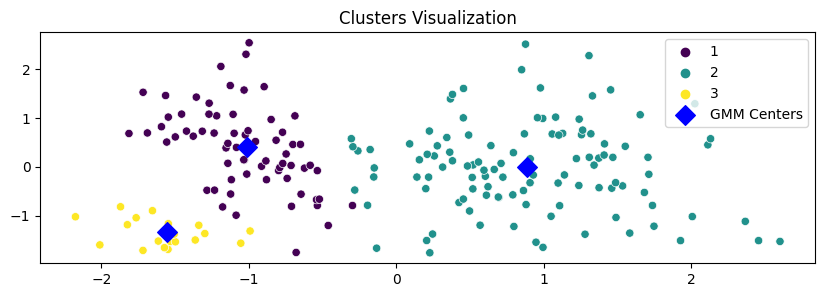

Cluster Centers:
0      1
1      3
2      2
3      3
4      2
      ..
193    1
194    2
195    1
196    2
197    1
Name: Cluster, Length: 198, dtype: int64


In [25]:
# Visualize clusters of GMM
plt.figure(figsize=(10, 3))
sns.scatterplot(x=data_clean_pca[:, 0], y=data_clean_pca[:, 1], hue=data_gmm['Cluster'], palette='viridis')
plt.scatter(model.means_[:, 0], model.means_[:, 1], s=100, c='blue', marker='D', label='GMM Centers')
plt.title('Clusters Visualization')
plt.legend()
plt.show()

print("Cluster Centers:")
print(data_gmm["Cluster"])

In [26]:
# Count numbers of data in each cluster
data_gmm['Cluster'].value_counts()

Cluster
2    111
1     68
3     19
Name: count, dtype: int64

In [27]:
data_clean.to_csv("Mall_Prediction_Cleaned")

## Model Prediction

In [28]:
# Assuming the label column is named 'label'
X = data_clean.drop('Cluster', axis=1)
y = data_clean['Cluster']

In [29]:
X

,Age,Annual Income (k$),Spending Score (1-100),Gender_Male
0,-1.424569,-1.738999,-0.434801,True
1,-1.281035,-1.738999,1.195704,True
2,-1.352802,-1.700830,-1.715913,False
3,-1.137502,-1.700830,1.040418,False
4,-0.563369,-1.662660,-0.395980,False
...,...,...,...,...
193,-0.061002,2.001605,1.583920,False
194,0.584899,2.268791,-1.327697,False
195,-0.276302,2.268791,1.118061,False
196,0.441365,2.497807,-0.861839,False


In [30]:
y

0      2
1      2
2      1
3      2
4      2
      ..
193    2
194    1
195    2
196    1
197    2
Name: Cluster, Length: 198, dtype: int32

In [31]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state = 42)

In [32]:
X_train.head()

,Age,Annual Income (k$),Spending Score (1-100),Gender_Male
51,-0.419835,-0.708425,0.380451,True
168,-0.204535,1.009200,-0.900660,False
38,-0.204535,-0.899272,-0.939482,False
31,-1.281035,-1.166458,0.885132,False
97,-0.850435,-0.021375,-0.007764,False


In [33]:
X_test.head()

,Age,Annual Income (k$),Spending Score (1-100),Gender_Male
65,-1.496335,-0.479408,0.341630,True
114,-1.496335,0.169472,-0.085407,False
16,-0.276302,-1.509983,-0.590088,False
141,-0.491602,0.551167,1.661563,True
156,-0.132768,0.665675,-1.910021,True


### Logistic regression


In [34]:
models = {

    "Logistic Regression ": LogisticRegression(random_state=1),
    "Logistic Regression L1": LogisticRegression(penalty='l1', solver='saga', random_state=1),
    "Logistic Regression L2": LogisticRegression(penalty='l2', random_state=1),
    "Logistic Regression ElasticNet": LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, random_state=1 ),

    #With C
    "Logistic Regression with C": LogisticRegression(random_state=1 , C = 0.5),
    "Logistic Regression L1 with C": LogisticRegression(penalty='l1', solver='saga', random_state=1 , C = 0.5),
    "Logistic Regression L2 with C": LogisticRegression(penalty='l2', random_state=1 , C = 0.5),
    "Logistic Regression ElasticNet with C": LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, random_state=1 , C = 0.5),
    #With weight
    "Logistic Regression with weight": LogisticRegression(random_state=1 ,class_weight = 'balanced' ),
    "Logistic Regression L1 with weight": LogisticRegression(penalty='l1', solver='saga', random_state=1 ,class_weight = 'balanced' ),
    "Logistic Regression L2 with weight": LogisticRegression(penalty='l2', random_state=1 ,class_weight = 'balanced' ),
    "Logistic Regression ElasticNet with weight": LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, random_state=1 ,class_weight = 'balanced' ),
    #With diff solvers
    "Logistic Regression with liblinear": LogisticRegression(random_state=1 , solver = 'liblinear'),
    "Logistic Regression with saga": LogisticRegression(solver='saga', random_state=1 ),
    "Logistic Regression with newton-cg": LogisticRegression( random_state=1 , solver = 'newton-cg' ),
    "Logistic Regression with newton-cholesky": LogisticRegression(solver='newton-cholesky'),
    "Logistic Regression with sag": LogisticRegression(solver='sag')

}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred)
    }

# Displaying the results
results_df = pd.DataFrame(results).T
print(results_df)

                                            Accuracy  Precision  F1 Score
Logistic Regression                              1.0        1.0       1.0
Logistic Regression L1                           1.0        1.0       1.0
Logistic Regression L2                           1.0        1.0       1.0
Logistic Regression ElasticNet                   1.0        1.0       1.0
Logistic Regression with C                       1.0        1.0       1.0
Logistic Regression L1 with C                    1.0        1.0       1.0
Logistic Regression L2 with C                    1.0        1.0       1.0
Logistic Regression ElasticNet with C            1.0        1.0       1.0
Logistic Regression with weight                  1.0        1.0       1.0
Logistic Regression L1 with weight               1.0        1.0       1.0
Logistic Regression L2 with weight               1.0        1.0       1.0
Logistic Regression ElasticNet with weight       1.0        1.0       1.0
Logistic Regression with liblinear    

### NB

#### GaussianNB

In [35]:
nb = GaussianNB()
nb.fit(X_train,y_train)
y_pred_test = nb.predict(X_test)
y_pred_train = nb.predict(X_train)
print(accuracy_score(y_train,y_pred_train))
print(accuracy_score(y_test,y_pred_test))

1.0
0.9833333333333333


### Decision Tree

In [36]:
dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)
y_pred_test = dt.predict(X_test)
y_pred_train = dt.predict(X_train)
print(accuracy_score(y_train,y_pred_train))
print(accuracy_score(y_test,y_pred_test))

1.0
0.9666666666666667


In [37]:
dt = DecisionTreeClassifier(
    max_depth= 5,
    min_samples_split= 2,
    min_samples_leaf= 10,
    max_features='sqrt',
    random_state=1
)

dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
y_pred_train = dt.predict(X_train)

results = {
    "Train accuracy": accuracy_score(y_train, y_pred_train),
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "F1 Score": f1_score(y_test, y_pred)
}

results_df = pd.DataFrame(results, index=[0])
print(results_df)

   Train accuracy  Accuracy  Precision  F1 Score
0        0.963768  0.983333   0.965517  0.982456


### Random Forest

In [38]:
rf = RandomForestClassifier(n_estimators=20)
rf.fit(X_train,y_train)
y_pred_test = rf.predict(X_test)
y_pred_train = rf.predict(X_train)
print(accuracy_score(y_train,y_pred_train))
print(accuracy_score(y_test,y_pred_test))

1.0
1.0


In [39]:
rf = RandomForestClassifier(n_estimators=200,
                            max_depth = 10,
                            min_samples_split = 5,
                            min_samples_leaf = 6,
                            max_features = 'sqrt',
                            random_state = 1
                            )
rf.fit(X_train,y_train)
y_pred_test = rf.predict(X_test)
y_pred_train = rf.predict(X_train)
print(accuracy_score(y_train,y_pred_train))
print(accuracy_score(y_test,y_pred_test))

1.0
0.9833333333333333
